In [1]:
import numpy as np

In [255]:
import distribution_modules as dm
import density_estimation_modules as dem
import classification_modules as cm
import importlib

importlib.reload(dm)
importlib.reload(dem)
importlib.reload(cm)

<module 'classification_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\classification_modules.py'>

In [271]:
# set configurations
sample_size = 50
nr_sample = 20
num_steps = 20
x_b = np.linspace(0,1,num_steps)
x_h = np.linspace(0,2,num_steps)

# cv config
test_size = 0.2
cv = 5
cv_config = [test_size, cv]

### Bounded distributions

In [219]:
bounded_dists = dm.get_bounded_distribution()
bounded_samples = dm.get_samples(bounded_dists, nr_sample, sample_size)
#dm.plot_histograms_of_samples(bounded_samples)

In [220]:
kde_df = dem.get_kde(bounded_samples, x_b)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,0.686630,0.778695,0.823295,0.820988,0.784065,0.731494,0.682712,0.652564,0.648606,0.671053,...,0.772973,0.837745,0.901605,0.955338,0.987058,0.983442,0.933867,0.835795,0.698139,arcsine
1,0.695824,0.832982,0.944239,1.021423,1.060354,1.061920,1.033215,0.986152,0.932817,0.880292,...,0.775493,0.719596,0.667430,0.629950,0.615047,0.619210,0.625543,0.611103,0.559462,arcsine
2,0.806827,0.886465,0.903947,0.868473,0.803253,0.735756,0.688554,0.674105,0.693538,0.738177,...,0.842718,0.875632,0.887944,0.881328,0.858332,0.818300,0.757236,0.671661,0.563403,arcsine


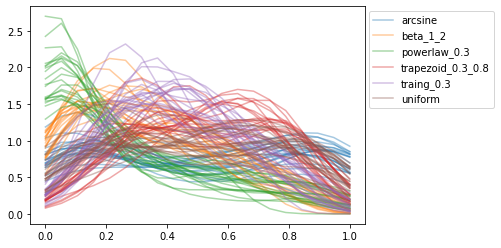

In [225]:
dem.get_kde_plot(kde_df,x_b)

### SVM

In [274]:
sample_size_list = [5, 10, 25, 50, 100, 500, 1000]
num_steps_list = list(np.arange(1,51))

In [259]:
res_svm = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, cv_config, 'kde', 1)

% completed:   0%|          | 0/7 [00:00<?, ?it/s]

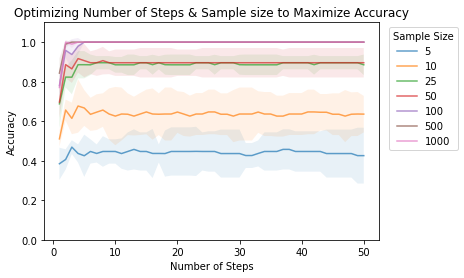

In [260]:
cm.plot_cv_numsteps_samplesize(res_svm)

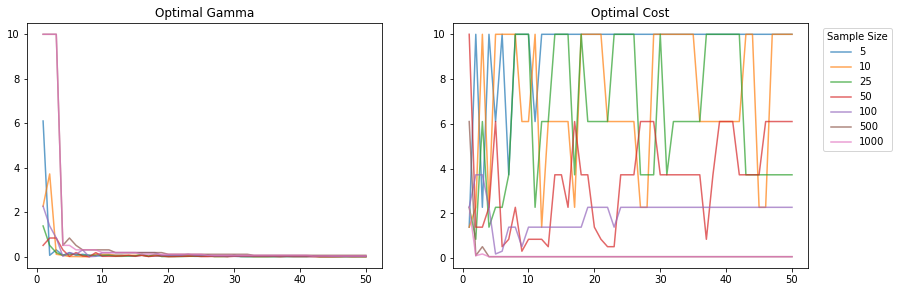

In [261]:
cm.plot_cv_h_params(res_svm)

### Logistic Regression

In [262]:
res_lr = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, cv_config, 'kde', 2)

% completed:   0%|          | 0/7 [00:00<?, ?it/s]

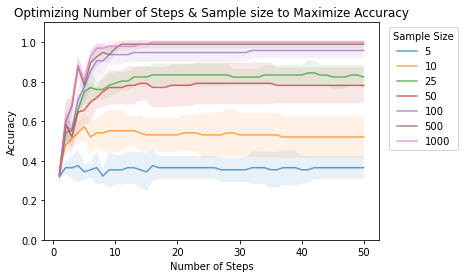

In [263]:
cm.plot_cv_numsteps_samplesize(res_lr)

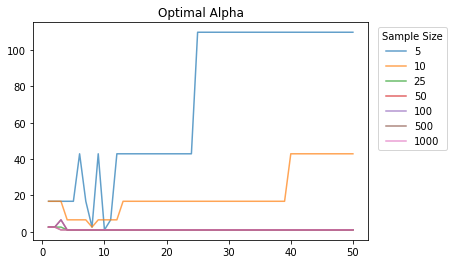

In [264]:
cm.plot_cv_h_params(res_lr)

In [101]:
import json
res_svm['num_steps'] = [int(i) for i in res_svm['num_steps']]
res_lr['num_steps'] = [int(i) for i in res_lr['num_steps']]

with open('results/kde/res_svm_bounded.json', 'w') as f:
    json.dump(res_svm, f)

with open('results/kde/res_lr_bounded.json', 'w') as f:
    json.dump(res_lr, f)

### Heavytail distributions

In [266]:
heavytail_dists = dm.get_heavytail_distribution()
heavytail_samples = dm.get_samples(heavytail_dists, nr_sample, sample_size, transform=True)
#dm.plot_histograms_of_samples(heavytail_samples)

In [272]:
kde_df = dem.get_kde(heavytail_samples, x_h)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,0.341617,0.442267,0.526357,0.584177,0.614810,0.624191,0.619905,0.606656,0.585277,0.554910,...,0.468906,0.417223,0.362659,0.307404,0.254416,0.207285,0.168834,0.139529,0.117225,cauchy
1,0.382405,0.466350,0.543155,0.604629,0.643679,0.655738,0.639812,0.598801,0.538940,0.468463,...,0.328256,0.270274,0.223759,0.188157,0.161379,0.140767,0.123884,0.108985,0.095141,cauchy
2,0.397802,0.491882,0.566846,0.617273,0.644634,0.653728,0.648114,0.628043,0.591981,0.539784,...,0.403062,0.332198,0.268580,0.216468,0.177375,0.150196,0.131976,0.119086,0.108245,cauchy


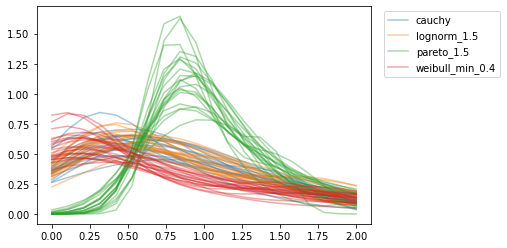

In [273]:
dem.get_kde_plot(kde_df,x_h)

### SVM

In [275]:
res_svm_ht = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, cv_config, 'kde', 1, transform=True)

% completed:   0%|          | 0/7 [00:00<?, ?it/s]

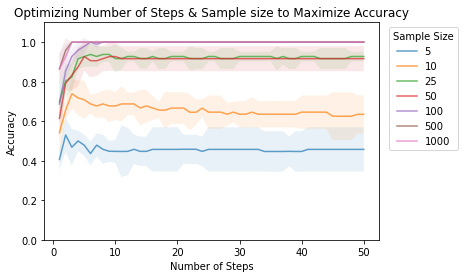

In [279]:
cm.plot_cv_numsteps_samplesize(res_svm_ht)

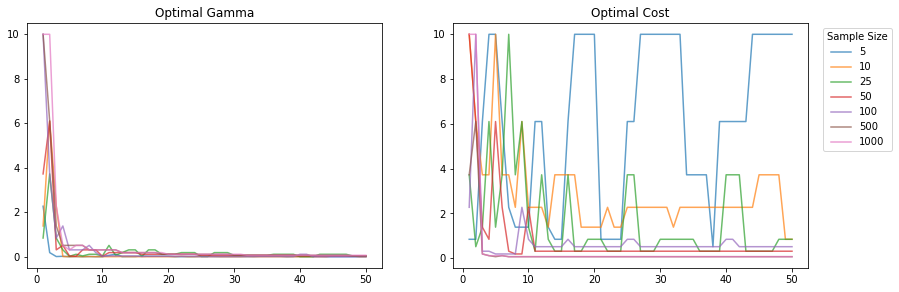

In [280]:
cm.plot_cv_h_params(res_svm_ht)

### Logististic Regression

In [281]:
res_lr_ht = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, heavytail_dists, nr_sample, cv_config, 'kde', 2, transform = True)

% completed:   0%|          | 0/7 [00:00<?, ?it/s]

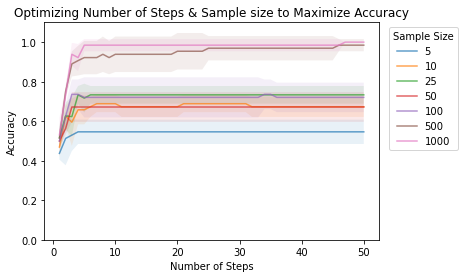

In [282]:
cm.plot_cv_numsteps_samplesize(res_lr_ht)

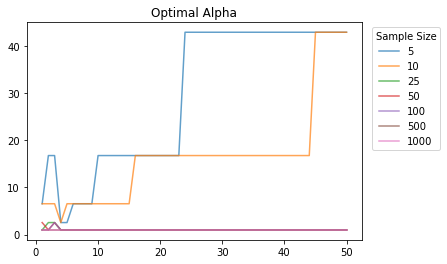

In [283]:
cm.plot_cv_h_params(res_lr_ht)

In [102]:
import json
res_svm_ht['num_steps'] = [int(i) for i in res_svm_ht['num_steps']]
res_lr_ht['num_steps'] = [int(i) for i in res_lr_ht['num_steps']]

with open('results/kde/res_svm_heavytail.json', 'w') as f:
    json.dump(res_svm_ht, f)

with open('results/kde/res_lr_heavytail.json', 'w') as f:
    json.dump(res_lr_ht, f)